Importing libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

Loading Datasets

In [96]:
data = pd.read_csv('PJME_hourly.csv')
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

Plotting Dataset

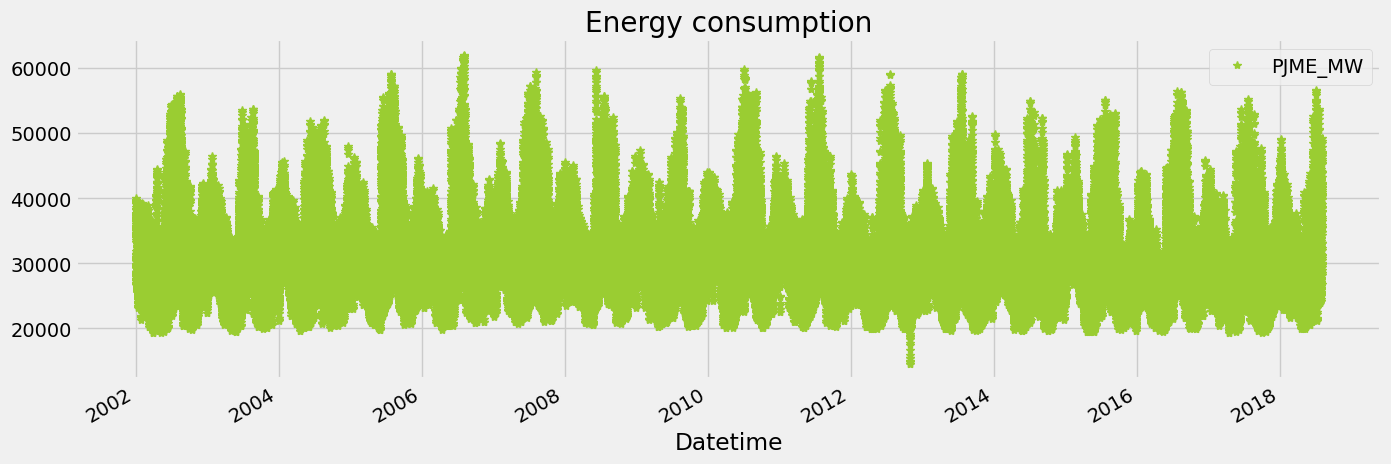

In [97]:
data.plot(style = '*',
          figsize=(15,5),
          color = 'yellowgreen',
          title = "Energy consumption")
plt.show()

Splitting train and test set

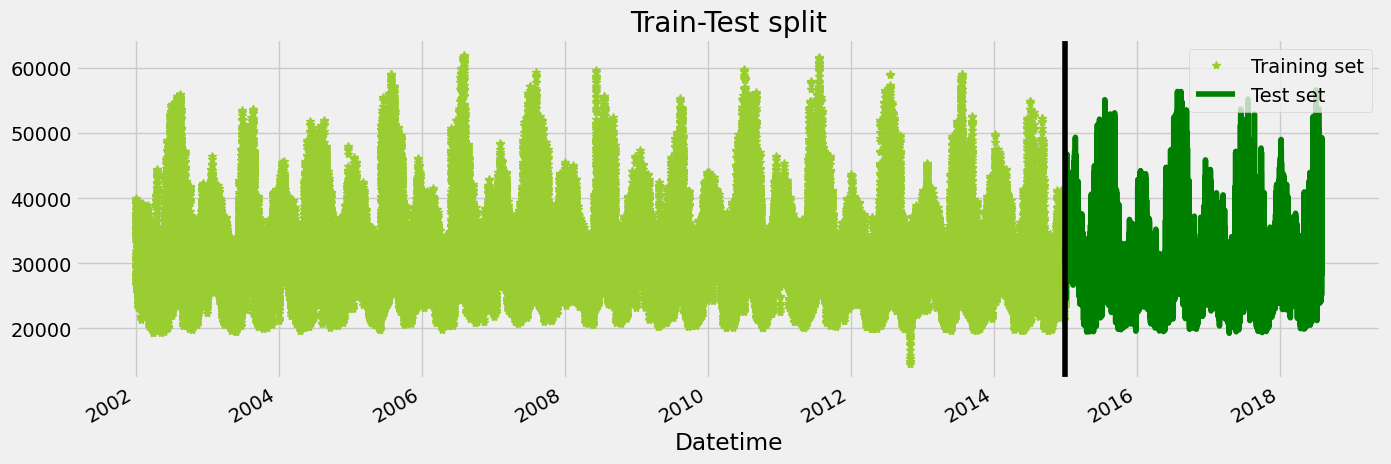

In [98]:
train = data.loc[data.index<'01-01-2015']
test = data.loc[data.index>='01-01-2015']

fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax = ax, color = 'yellowgreen', style = '*',label = 'train set', title = 'Train-Test split')
test.plot(ax = ax,color = 'green',label = 'test set')
ax.axvline('01-01-2015', color = 'black', ls ='solid')
ax.legend(['Training set','Test set'])
plt.show()



Week of a data

<Axes: title={'center': 'Weekly Analysis'}, xlabel='Datetime'>

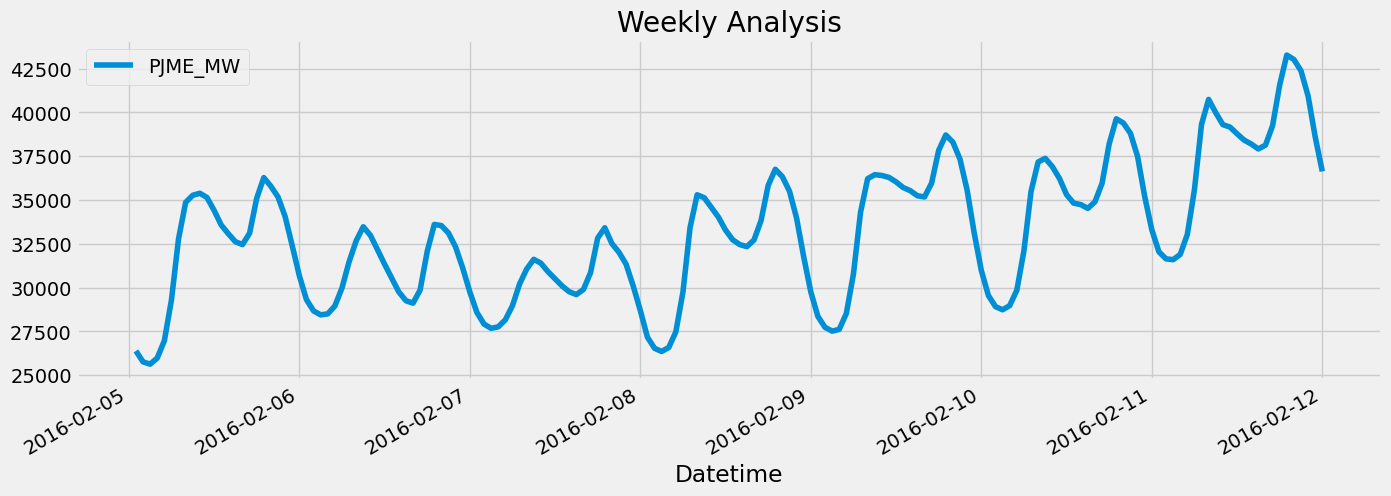

In [99]:
df = data.loc[(data.index > '02-05-2016') & (data.index <= '02-12-2016')]
df.plot(figsize = (15,5), title = "Weekly Analysis")

Creating features

In [100]:
def feature_dataset(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = feature_dataset(df)

Create model

In [101]:
train = feature_dataset(train)
test = feature_dataset(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_test
y_test

Datetime
2015-01-01 00:00:00    32802.0
2015-12-31 01:00:00    24305.0
2015-12-31 02:00:00    23156.0
2015-12-31 03:00:00    22514.0
2015-12-31 04:00:00    22330.0
                        ...   
2018-01-01 20:00:00    44284.0
2018-01-01 21:00:00    43751.0
2018-01-01 22:00:00    42402.0
2018-01-01 23:00:00    40164.0
2018-01-02 00:00:00    38608.0
Name: PJME_MW, Length: 31440, dtype: float64

Improving performance using XGboost

In [102]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=500)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:07:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[989]	validation_0-rmse:3059.85847	validation_1-rmse:3727.94591


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

Forecasting

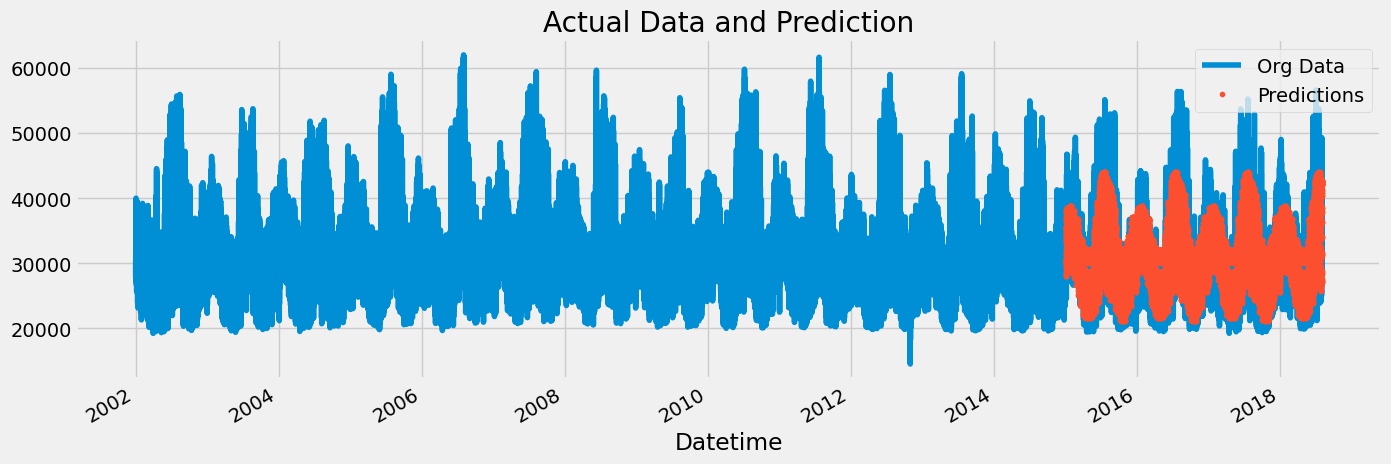

In [103]:
test['prediction'] = reg.predict(X_test)
data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = data[['PJME_MW']].plot(figsize=(15, 5))
data['prediction'].plot(ax=ax, style='.')
plt.legend(['Org Data', 'Predictions'])
ax.set_title('Actual Data and Prediction')
plt.show()

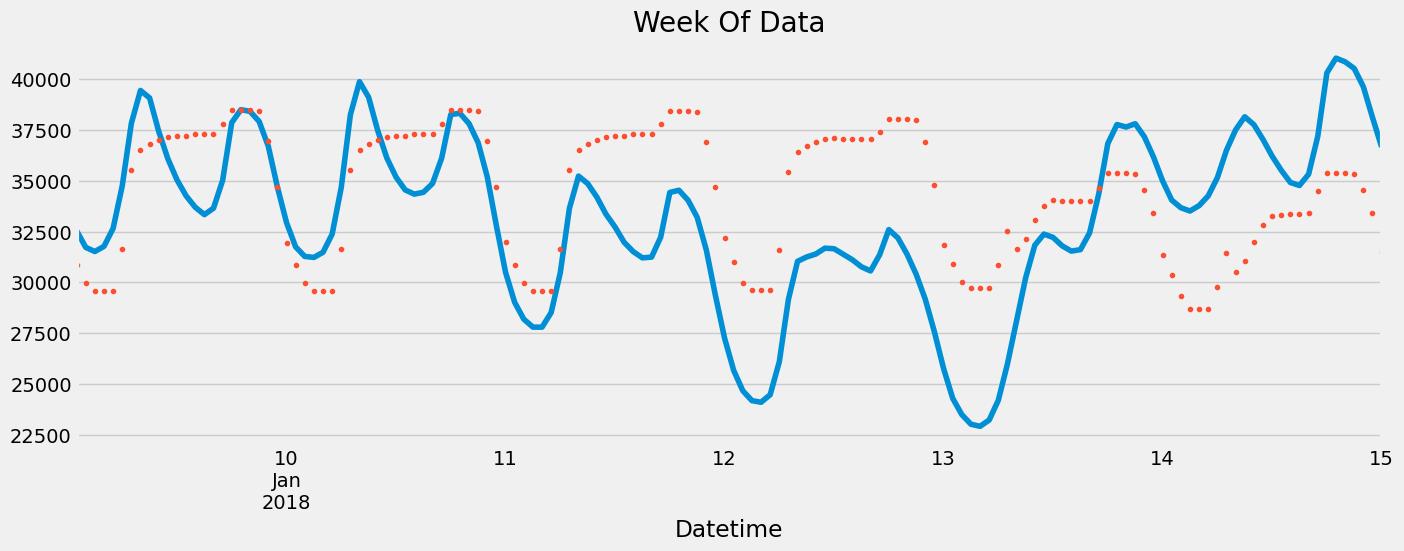

In [104]:
ax = data.loc[(data.index > '01-09-2018') & (data.index <= '01-15-2018')]['PJME_MW']\
      .plot(figsize=(15, 5), title='Week Of Data')
data.loc[(data.index > '01-09-2018') & (data.index <= '01-15-2018')]['prediction'] \
    .plot(style='.')
plt.show()


Mean squared error score

In [105]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


Calculating error

In [106]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    322.958008
2015-10-28    426.451335
2016-10-27    543.167155
2015-05-06    556.749674
2017-10-15    569.468262
2018-05-16    569.951009
2015-11-06    678.310140
2017-04-07    687.475911
2016-12-29    706.143392
2016-09-16    711.019694
Name: error, dtype: float64